# Train the model

In [1]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# load stage 3A test data as extra training set (avoid catastrophic forgetness)
# already normalized but thats probably ok
f_path = 'regression_training/stage1C/1B_test_X.txt'
X1 = pd.read_csv(f_path)
X1 = X1.drop(X1.columns[0],axis = 1)
X1 = X1.drop(0,axis = 0)

f_path = 'regression_training/stage1C/1B_test_y.txt'
y1 = pd.read_csv(f_path)
y1 = y1.drop(y1.columns[0],axis = 1)
y1 = y1.drop(0,axis = 0)

In [3]:
# load data
f_path = 'regression_training/stage1C/y.txt'
y = pd.read_csv(f_path)
y = y.drop(y.columns[0],axis = 1)
y = y.drop(0,axis = 0)

f_path = 'regression_training/stage1C/X.txt'
X = pd.read_csv(f_path)
X = X.drop(X.columns[0],axis = 1)
X = X.drop(0,axis = 0)

In [4]:
# append stage 1 and 2 data
y1.columns = ["m1","m2"]
yy = pd.concat([y, y1],axis=0,ignore_index=True)
XX = pd.concat([X, X1],axis=0,ignore_index=True)

In [5]:
X_t = XX.transpose()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_t)
X_scaled = pd.DataFrame(X_scaled.transpose())

In [6]:
# Train test split with sklearn
Xtrain,Xtest,y_train,y_test = train_test_split(X_scaled.values,yy.values,test_size=0.1,random_state=13)

In [7]:
# Reshape data
X_train = []
for i in np.arange(len(Xtrain)):
    h = Xtrain[i].reshape(4096,1)
    X_train.append(h)
X_train = np.asarray(X_train)

X_test = []
for i in np.arange(len(Xtest)):
    h = Xtest[i].reshape(4096,1)
    X_test.append(h)
X_test = np.asarray(X_test)

In [8]:
# Check model performance accuracy before

model = load_model("regression_stage1B.h5")
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss 1:', score[0])
print('Test accuracy 1:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1160/1160 [==============================] - 3s 3ms/step
Test loss 1: 3.537305498123169
Test accuracy 1: 25.430853258330245


In [9]:
# Continue training
epoch = 200
batch_size = 5

earlystopping_callback = EarlyStopping(monitor='mean_squared_error',verbose=1,min_delta=0.5,patience=5,baseline=None)

record = model.fit(X_train, y_train, validation_split = 0.20, batch_size=batch_size, epochs=epoch, verbose=1,
                   callbacks=[earlystopping_callback])

Train on 8348 samples, validate on 2087 samples
Epoch 1/200
8348/8348 [==============================] - 137s 16ms/step - loss: 2.3921 - mean_squared_error: 10.4669 - mean_absolute_error: 2.3921 - val_loss: 2.3409 - val_mean_squared_error: 9.9103 - val_mean_absolute_error: 2.3409
Epoch 2/200
8348/8348 [==============================] - 101s 12ms/step - loss: 2.1720 - mean_squared_error: 8.5071 - mean_absolute_error: 2.1720 - val_loss: 1.9917 - val_mean_squared_error: 6.8310 - val_mean_absolute_error: 1.9917
Epoch 3/200
8348/8348 [==============================] - 98s 12ms/step - loss: 2.0604 - mean_squared_error: 7.6918 - mean_absolute_error: 2.0604 - val_loss: 2.6251 - val_mean_squared_error: 12.2027 - val_mean_absolute_error: 2.6251
Epoch 4/200
8348/8348 [==============================] - 104s 12ms/step - loss: 2.0015 - mean_squared_error: 7.2972 - mean_absolute_error: 2.0015 - val_loss: 2.0872 - val_mean_squared_error: 8.1784 - val_mean_absolute_error: 2.0872
Epoch 5/200
8348/8348 [

In [10]:
# Save model
model.save('regression_stage1C.h5')  # creates a HDF5 file 'my_model.h5'

In [11]:
# Save test data
X_test_df = pd.DataFrame(Xtest)
f_path = 'regression_training/stage2A/1C_test_X.txt'
X_test_df.to_csv(f_path)
y_test_df = pd.DataFrame(y_test)
f_path = 'regression_training/stage2A/1C_test_y.txt'
y_test_df.to_csv(f_path)

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


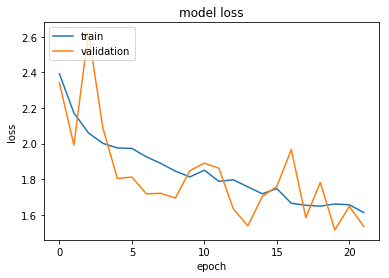

In [12]:
print(record.history.keys())
# "Loss"
plt.plot(record.history['loss'])
plt.plot(record.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Prediction

/Users/DRRRR/anaconda/envs/machinelearning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


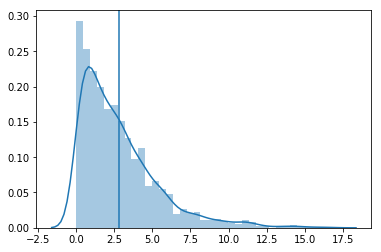

Mean %difference: 2.803095225766957
Standard deviation of %difference: 2.5294362674245683


In [13]:
preds = model.predict(X_test)
 
# compute the difference between the *predicted* and *actual* 
# then compute the percentage difference and the absolute percentage difference
diff = preds.flatten() - y_test.flatten()
percentDiff = (diff / y_test.flatten()) * 100
absPercentDiff = np.abs(percentDiff)
 
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

sns.distplot(absPercentDiff)
plt.axvline(mean, 0,1)
plt.show()

print("Mean %difference:",mean)
print("Standard deviation of %difference:",std)

In [16]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss :', score[0])
print('Test accuracy:', score[1])

1160/1160 [==============================] - 3s 3ms/step
Test loss : 1.455291463588846
Test accuracy: 3.589965527633141


In [21]:
absPercentD = absPercentDiff.reshape(len(y_test),2)
count = 0
percentage_cut = 12

grad = []
badmass = []


for i in np.arange(len(absPercentD)):
    if absPercentD[i][0]>percentage_cut or absPercentD[i][1]>percentage_cut:
        count += 1
        grad.append(max(absPercentD[i][0],absPercentD[i][1]))
        badmass.append(y_test[i])
        print()
        print("Absolute Percent Difference: ",absPercentD[i])
        print("Actual masses: ",y_test[i])
        print("Predicted masses: ",preds[i])

print()
print("A total number of ", count, " predictions have above ", percentage_cut, " absolute percent difference.")


Absolute Percent Difference:  [13.30686416  7.77672915]
Actual masses:  [29.38321671 44.82607922]
Predicted masses:  [33.2932   41.340076]

Absolute Percent Difference:  [13.35864317  6.33590731]
Actual masses:  [32.4081963  48.76567819]
Predicted masses:  [36.73749 45.67593]

Absolute Percent Difference:  [16.75160819  2.62081537]
Actual masses:  [36.30570387 97.90327403]
Predicted masses:  [42.387493 95.33741 ]

Absolute Percent Difference:  [12.20936494  2.8005946 ]
Actual masses:  [11.60305714 93.22775268]
Predicted masses:  [10.186398 95.838684]

Absolute Percent Difference:  [12.32357129  6.02364809]
Actual masses:  [26.83834725 49.66627857]
Predicted masses:  [30.14579  46.674557]

Absolute Percent Difference:  [13.92246617  5.89607224]
Actual masses:  [26.07065625 48.20436593]
Predicted masses:  [29.700335 45.3622  ]

Absolute Percent Difference:  [14.4619462   5.95410758]
Actual masses:  [52.39916178 70.44700025]
Predicted masses:  [59.9771  66.25251]

Absolute Percent Differ

In [22]:
# make panda dataframe
summary = pd.DataFrame(badmass,columns = ["m1","m2"])
summary['percentage']=grad

Blues = plt.get_cmap('Blues')
norm = [float(i)/max(grad) for i in grad]
colors = [Blues(c) for c in norm]

summary['colors']=colors

# For stage 1B data generation

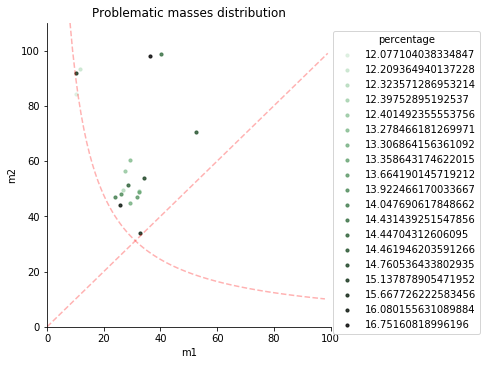

In [23]:
# Summary for training data 1B:

sns.lmplot(x="m1", y="m2",
           hue="percentage",
           data = summary,
           fit_reg=False,
           scatter_kws={"marker": "D",
                        "s": 10},
           palette = sns.cubehelix_palette(len(colors), start=2, rot=0, dark=0, light=.9))

plt.plot(np.arange(100),'r--',alpha=0.3)
plt.plot(1000/np.arange(1,100),'r--',alpha=0.3)

plt.title('Problematic masses distribution')
plt.xlabel('m1')
plt.ylabel('m2')
plt.ylim(0,110)
plt.xlim(0,100)
plt.show()